# [Mobile AI & AIM 2022 Learned Smartphone ISP Challenge](https://codalab.lisn.upsaclay.fr/competitions/1759)
## Unofficial baseline
### Marcos Conde (JMU-CVLab) https://github.com/mv-lab/AISP


<img src=https://i.ibb.co/wgRBGQq/aim-challenge-teaser.jpg>


**Description of this baseline**

- End-to-End: Dataloading, training and submission, all here.
- Tensorflow framwork
- We show how to deal with RAW data using native tensorflow
- We train a model inspired in `Smallnet` from team *dh_isp*, top solution at the [MAI 2021 Learned ISP Challenge](https://arxiv.org/pdf/2105.07809.pdf)
- We convert the model to tflite and prepare a submission to the challenge

You should also check the other **Related Challenges**

## [AIM 2022](https://data.vision.ee.ethz.ch/cvl/aim22/) - Reversed ISP Challenge

### [Track 1 - S7](https://codalab.lisn.upsaclay.fr/competitions/5079) | [Track 2 - HP20](https://codalab.lisn.upsaclay.fr/competitions/5080)

In [9]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import gc
import time
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import imageio
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

print (tf.__version__)

2.4.1


In [10]:
DEVICE   = "GPU" #or "TPU"
strategy = tf.distribute.get_strategy()
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
REPLICAS: 1


## Utils from https://github.com/mv-lab/AISP

In [11]:
def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
    return img
    
def plot_all (images, axis='off'):
    fig = plt.figure(figsize=(12, 6), dpi=80)
    
    nplots = len(images)
    
    for i in range(nplots):
        
        plt.subplot(1,nplots,i+1)
        plt.axis(axis)
        plt.imshow(images[i])

    plt.show()
    
def np_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [12]:
########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
     
    source: https://github.com/mv-lab/AISP
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image

def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    
    Source: https://github.com/mv-lab/AISP
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

# Dataset

In [13]:
all_raw_images = sorted(glob('../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/mediatek_raw/*.png'))
all_rgb_images = sorted(glob('../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/fujifilm/*.png'))

train_inps, valid_inps, train_gts, valid_gts = train_test_split(all_raw_images, all_rgb_images, test_size=0.05, random_state=42)

assert len(train_inps) == len(train_gts)
assert len(valid_inps) == len(valid_gts)

print ('All images', len(all_raw_images))
print (f'Training {len(train_inps)} samples. Validation samples { len(valid_inps)}')
train_inps[:2], train_gts[:2], valid_inps[:2], valid_gts[:2]

All images 24161
Training 22952 samples. Validation samples 1209


(['../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/mediatek_raw/19687.png',
  '../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/mediatek_raw/2051.png'],
 ['../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/fujifilm/19687.png',
  '../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/fujifilm/2051.png'],
 ['../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/mediatek_raw/2752.png',
  '../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/mediatek_raw/17223.png'],
 ['../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/fujifilm/2752.png',
  '../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_train/fujifilm/17223.png'])

## Visualization

We can visualize the RGB images and the RAW images using a simple demosaic function.

This implementation allows to load the RAW images using native tensorflow, the resultant 4-channel RAW images follow the RGGB pattern.

A simple postprocessing (gamma and tone mapping) is used to better visualize the RAW images.

(256, 256, 3) (128, 128, 4) 0.07519531 0.99902344


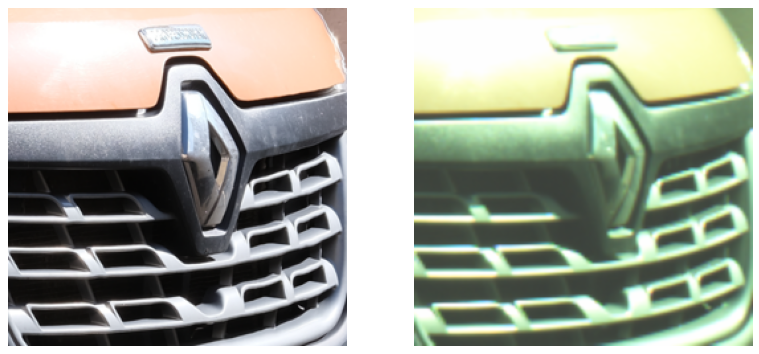

(256, 256, 3) (128, 128, 4) 0.0703125 0.99902344


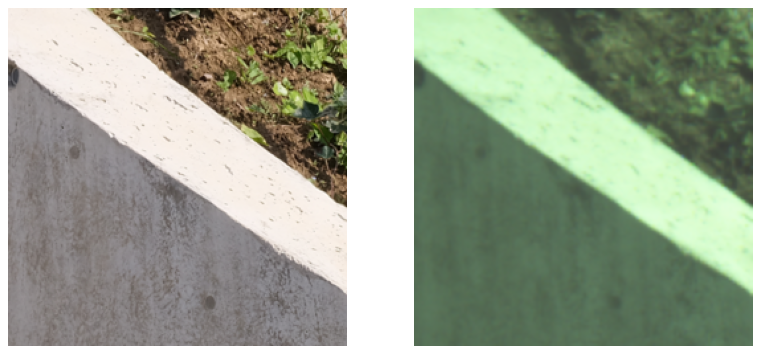

(256, 256, 3) (128, 128, 4) 0.06542969 0.39257812


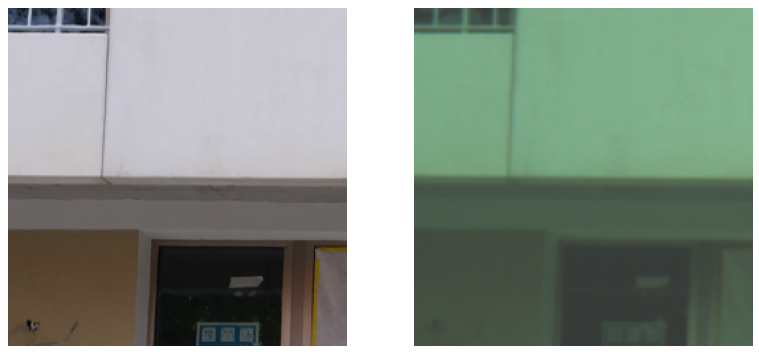

(256, 256, 3) (128, 128, 4) 0.06347656 0.2265625


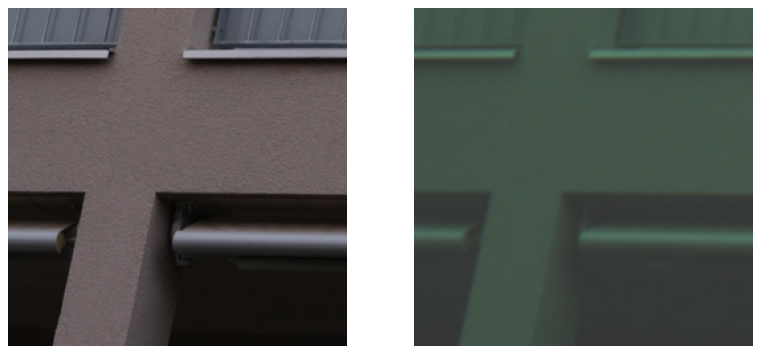

(256, 256, 3) (128, 128, 4) 0.068359375 0.7685547


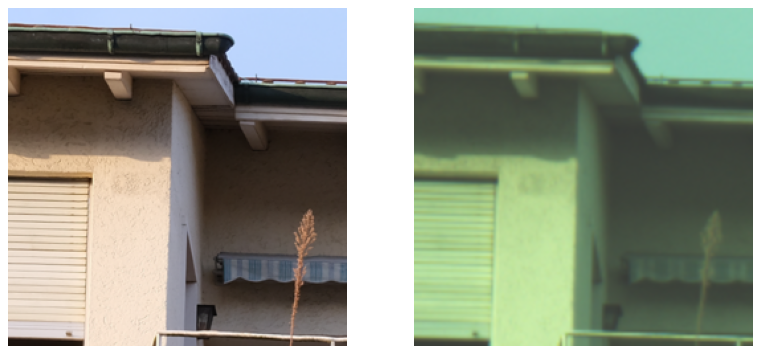

(256, 256, 3) (128, 128, 4) 0.08496094 0.99902344


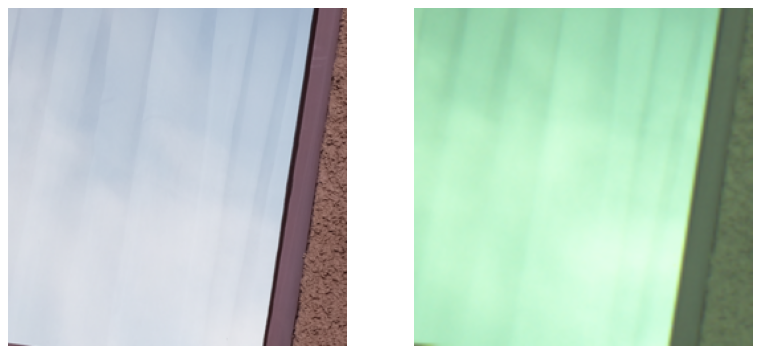

(256, 256, 3) (128, 128, 4) 0.06933594 0.99902344


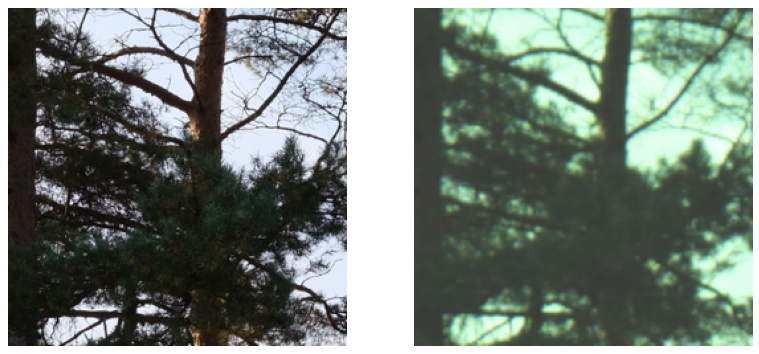

In [14]:
cnt = 0
for fraw, frgb in zip(train_inps, train_gts):

    rgb = load_img(frgb)
    
    #raw = np.asarray(imageio.imread(fraw))
    
    file_bytes = tf.io.read_file(fraw)
    raw = tf.io.decode_png(file_bytes,channels=1,dtype=tf.uint16)
    raw = tf.reshape(raw, [256, 256, 1])
    raw = tf.expand_dims(raw, 0)
    raw = tf.nn.space_to_depth (raw, 2) ## RGGB
    raw = tf.squeeze(raw).numpy()
    raw = raw.astype(np.float32) / 2**12
    
    print (rgb.shape, raw.shape, raw.min(), raw.max())

    plot_all([rgb, postprocess_raw(demosaic(raw))])
    
    if cnt > 5: break
    cnt +=1

# Dataloader

We provide native Tensorflow dataloader to speed-up dataloading during training.

In [15]:
def tf_demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    raw.shape.assert_is_compatible_with((None, None, 4))
    shape = tf.shape(raw)
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = tf.stack((red, avg_green, blue), axis=-1)
    image      = tf.reshape(image, [shape[1], shape[0], 3])
    image      = tf.image.resize(image, [shape[1]*2, shape[0]*2])
    return image

In [16]:
def build_decoder(with_labels=True, inp_size=[256,256,3]):
    
    def decode(path):
        #print ('decoding rgb')
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_png(file_bytes,channels=3,dtype=tf.uint8)
        img = tf.reshape(img, inp_size)
        img = tf.cast(img, tf.float32)
        img = img / 255.
        return img
    
    def decode_raw(path):
        '''
        RAW images are decoded as 4-channel RGGB images and normalized assuming 12-bit maximum value.
        The original code for loading the RAW images uses 4**255 (aprox 2**10), but is easy to see that images are not normalized properly
        using that value. We find 2**12 the proper max_value.
        https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp/blob/master/load_dataset.py#L21
        '''
        #print ('decoding raw')
        file_bytes = tf.io.read_file(path)
        raw = tf.io.decode_png(file_bytes,channels=1,dtype=tf.uint16)
        raw = tf.reshape(raw, [256, 256, 1])
        raw = tf.nn.space_to_depth (tf.expand_dims(raw,0), 2)
        raw = tf.squeeze(raw)
        raw = raw / 2**12
        raw = tf.cast(raw, tf.float32)
        #raw = tf_demosaic(raw)
        return raw
    
    def decode_with_labels(path, label):
        return decode_raw(path), decode(label)
    
    return decode_with_labels if with_labels else decode

### Classical Augmentations

In [17]:
def random_rotate90(image, rotate_prob):
    """
    randomly rotates an image by a factor of 90 degree
    """
    if rotate_prob > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    
    elif rotate_prob > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    
    elif rotate_prob > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    return image

def random_flip(image, flip_prob):
    """
    Randomly flips the given image along its dimensions. 
    The flip maybe horizontal or vertical.
    """
    if flip_prob > 0.5 :
        image = tf.image.flip_up_down(image)
    else:
        image = tf.image.flip_left_right(image) 
    return image

    
def build_augmenter(with_labels=True):
    def augment(img):
        return img
    
    def augment_with_labels(img, label):
        
        rotate_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        flip_prob   = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        do_flip = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        do_rot  = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        do_tran = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
        
        if do_flip > 0.5:
            img   = random_flip(img, flip_prob)
            label = random_flip(label, flip_prob)
        
        if do_rot > 0.5:
            img   = random_rotate90(img, rotate_prob)
            label = random_rotate90(label, rotate_prob)
        if do_tran > 0.5:
            img   = tf.image.transpose(img)
            label = tf.image.transpose(label)
        
        img   = tf.clip_by_value(img, 0, 1)
        label = tf.clip_by_value(label, 0, 1)
        img   = tf.cast(img, tf.float32)
        label = tf.cast(label, tf.float32)
        return img, label
    
    return augment_with_labels if with_labels else augment

In [18]:
def build_dataset(paths, labels=None, bsize=16, augment=False, repeat=True, shuffle=True, val=False, test=False, cache=False):
    
    if val or test:
        shuffle = False ; repeat  = False

    if test:
        decode_fn  = test_decode
    else:
        decode_fn  = build_decoder(labels is not None)
    
    if augment:
        augment_fn = build_augmenter(labels is not None)
        
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(2000) if shuffle else dset
    dset = dset.batch(bsize, drop_remainder=True)
    dset = dset.prefetch(AUTO)
    return dset

## Check dataloading

Loaded batches: (8, 128, 128, 4) (8, 256, 256, 3)


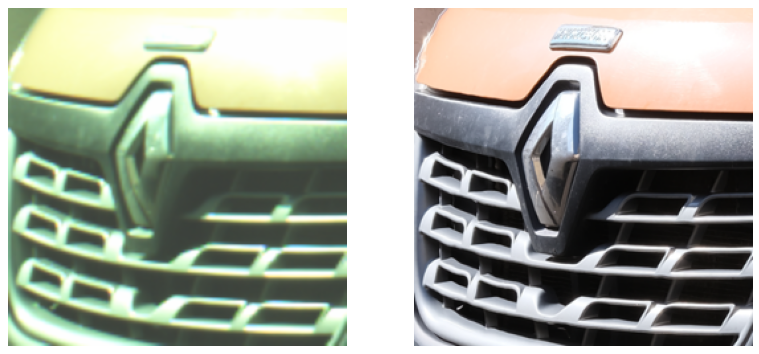

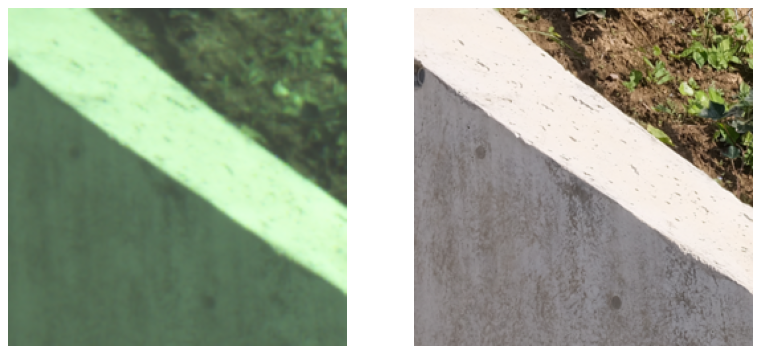

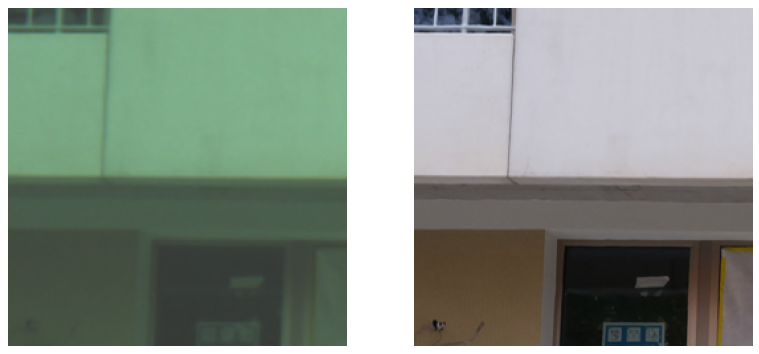

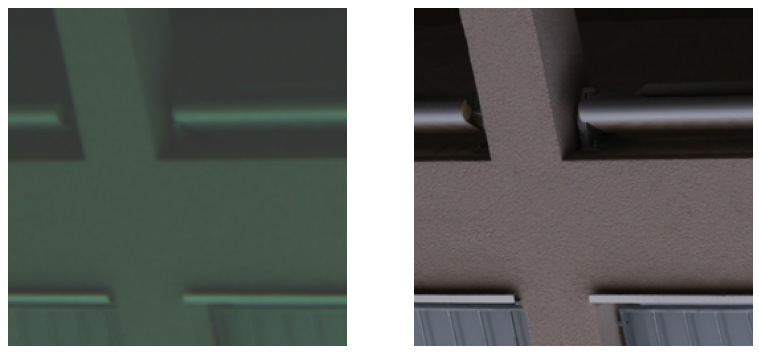

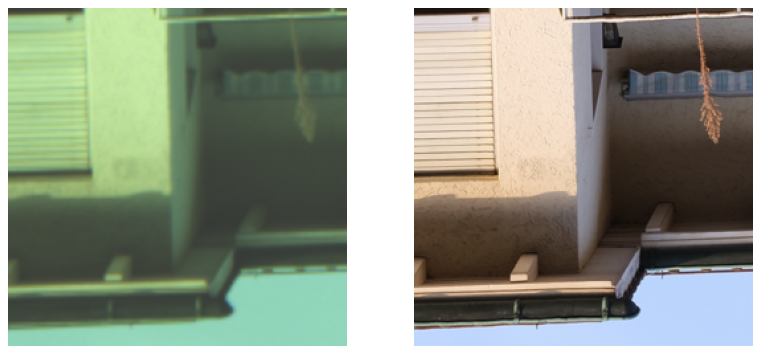

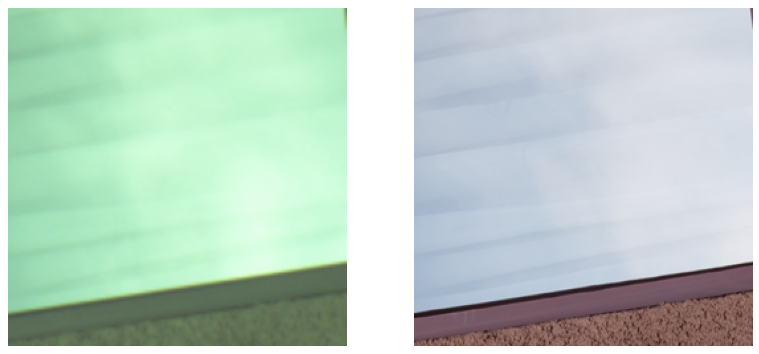

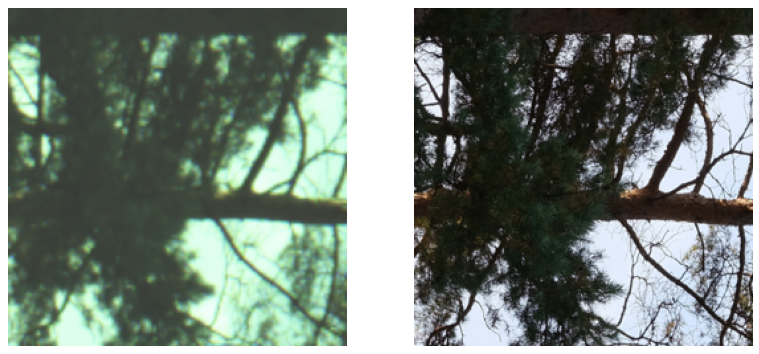

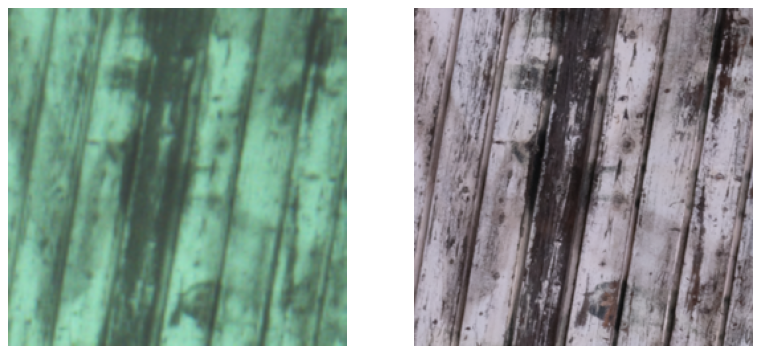

54504

In [19]:
dummy_dataset = build_dataset(train_inps, train_gts, bsize=8, shuffle=False, augment=True, val=False)
dummy_dataset = dummy_dataset.unbatch().batch(8)
dummy_batch   = iter(dummy_dataset)

# run this cell again for another randomized set of training images
batch = next(dummy_batch )
raws = batch[0]
rgbs = batch[1]

print ('Loaded batches:', raws.shape, rgbs.shape)

for _inp, _gt in zip(raws, rgbs):
    plot_all([postprocess_raw(demosaic(_inp)), _gt])

del batch, raws, rgbs, dummy_batch, dummy_dataset
gc.collect()

# Training 

### Loss and Metrics

In [20]:
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

def sum_squared_error(y_true, y_pred):
    return (K.sum(K.square(y_pred - y_true))/2)

def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true,y_pred, max_val=1.0)

def loss_f(y_true, y_pred):
    _ssim = K.mean(1 - ssim(y_true,y_pred))
    _loss = K.mean(tf.keras.losses.mean_absolute_error(y_true, y_pred))
    return 0.085*_ssim + _loss

## Model 

In [21]:
'''
Keras implementation of "CBAM: Convolutional Block Attention Module".
https://github.com/kobiso/CBAM-keras
'''

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    channel = input_feature.shape[-1]
    cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    return multiply([input_feature, cbam_feature])
    

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def attention_block (x, dim=16):
    
    inputs = x
    
    x = tf.keras.layers.Conv2D(dim, (3,3), strides=(1,1), 
                               padding="same", 
                               activation='relu')(x)
    
    shortcut = x
    
    gap = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x)
    gmp = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x)
    
    ## spatial attention
    gap_gmp = Concatenate(axis=3)([gap, gmp])
    gap_gmp = tf.keras.layers.Conv2D(dim, (3,3), strides=(1,1), 
                               padding="same", 
                               activation='sigmoid')(gap_gmp)
    
    spatial_attention = multiply([shortcut, gap_gmp])
    
    ## channel attention
    x1 = tf.keras.layers.Conv2D(dim, (1,1), strides=(1,1), 
                               padding="same", 
                               activation='relu')(gap)
    x1 = tf.keras.layers.Conv2D(dim, (1,1), strides=(1,1), 
                               padding="same", 
                               activation='sigmoid')(x1)
    
    channel_attention = multiply([shortcut, x1])
    
    
    attention = Concatenate(axis=3)([spatial_attention, channel_attention])
    x2 = tf.keras.layers.Conv2D(dim, (1,1), strides=(1,1), 
                               padding="same", 
                               activation='relu')(attention)
    
    input_project = tf.keras.layers.Conv2D(dim, (1,1), strides=(1,1), 
                               padding="same", 
                               activation='relu')(inputs)
    
    out = Add()([input_project, x2])
    return out
    

def DAB (x, dim=32):
    '''Dual Attention Block
    source: https://github.com/swz30/CycleISP'''
    
    shortcut = x
    x = tf.keras.layers.Conv2D(dim, (3,3), strides=(1,1), padding="same", activation='relu')(x)
    x = tf.keras.layers.Conv2D(dim, (3,3), strides=(1,1), padding="same", activation= None)(x)
    
    channel_att = channel_attention(x, ratio=8)
    spatial_att = spatial_attention(x)
    dual_att = Concatenate(axis=-1)([channel_att, spatial_att])
    act = tf.keras.layers.Conv2D(dim, (1,1), strides=(1,1), padding="same", activation= None)(dual_att)
    out = Add()([shortcut, act])
    return out

def RRG(x,dim=32):
    '''Recursive Residual Group
    source: https://github.com/swz30/CycleISP'''
    shortcut = x
    x = attention_block(x,dim) #DAB(x, dim)
    x = tf.keras.layers.Conv2D(3, (3,3), strides=(1,1), padding="same", activation='relu')(x)
    out = out = Add()([shortcut, x])
    return out

## Config

In [101]:
class CFG:
    
    MONITOR     = 'val_PSNR'
    NAME        = 'model_isp_final_23_46'
    START_EPOCH = 40
    EPOCHS      = 50
    CKPT_FILE   = f'{NAME}.h5'
    PRE_MODEL   = './model_isp_final_23_42_last.h5'
    SMALLNET    = None #'../input/isp-models/model_smallnet_isp.h5'
    TRAINING    = True
    BATCH_SIZE  = 32
    LRATE       = 1e-5
    INPUT_DIM   = (None, None, 4)

In [102]:
def build_model(input_shape=(None, None, 4)):
    '''
    Model inspired in Smallnet from team dh_isp, top solution at the MAI 2021 Learned ISP Challenge (https://arxiv.org/pdf/2105.07809.pdf)
    1) first we train smallnet
    2) we freeze it and add some CBAM attention blocks on top, we train them alone
    3) we optimize the entire model using a lower LR.
    '''

    inputs = tf.keras.layers.Input(input_shape)
        
    c1 = tf.keras.layers.Conv2D(16, (3,3), strides=(1,1), padding="same", activation='tanh')(inputs)
    c2 = tf.keras.layers.Conv2D(16, (3,3), strides=(1,1), padding="same", activation='relu')(c1)
    c3 = tf.keras.layers.Conv2D(12, (3,3), strides=(1,1), padding="same", activation='relu')(c2)
    
    rgb = tf.nn.depth_to_space(c3, 2)
    rgb = tf.math.pow((rgb + 1e-8) , (1.0 / 2.2)) # gamma
    rgb = (3*tf.math.pow(rgb,2)) - (2*tf.math.pow(rgb,3)) # s-curve tonemap
    base= tf.keras.models.Model(inputs=[inputs], outputs=[rgb])
    
    if CFG.SMALLNET:
        base.load_weights(CFG.SMALLNET)
        print ('smallnet model loaded')
        for layer in base.layers:
            layer.trainable=False
        print ('smallnet model frozen')
    
    x1 = tf.keras.layers.Conv2D(32, (3,3), strides=(1,1), padding="same", activation='relu', name='conv_expand')(rgb)
    x1 = cbam_block(x1)
    x1 = tf.keras.layers.Conv2D(3, (3,3), strides=(1,1), padding="same", activation='tanh', name='conv_remap')(x1)
    x1 = rgb + x1
    
    out = tf.clip_by_value(x1, 0., 1.)
    #out = tf.keras.layers.Conv2D(3, (3,3), strides=(1,1), padding="same", activation='relu', name='conv_remap')(x)
    
    opt = tf.keras.optimizers.Adam(lr=CFG.LRATE)
    model = tf.keras.models.Model(inputs=[inputs], outputs=[out])
    model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', PSNR,ssim])
    return model

In [103]:
train_dataset = build_dataset(train_inps, train_gts, bsize=CFG.BATCH_SIZE, shuffle=True, augment=True, val=False, test=False)
valid_dataset = build_dataset(valid_inps, valid_gts, bsize=CFG.BATCH_SIZE, shuffle=False, augment=False, val=True, test=False)

steps_per_epoch = len(train_inps) // CFG.BATCH_SIZE
print (f'Steps per epoch {steps_per_epoch}, batch size {CFG.BATCH_SIZE}, training samples {len(train_inps)}, valid samples {len(valid_inps)}')

Steps per epoch 717, batch size 32, training samples 22952, valid samples 1209


In [104]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CFG.CKPT_FILE, monitor=CFG.MONITOR, save_freq='epoch', save_best_only=True, save_weights_only=True, mode = 'max', verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=CFG.MONITOR, mode = 'max',factor=0.5, patience=3, min_lr=1e-6, verbose=1)
stop = tf.keras.callbacks.EarlyStopping(monitor=CFG.MONITOR, mode = 'max',patience=5, verbose=1, restore_best_weights=True)

In [105]:
tf.keras.backend.clear_session()

with strategy.scope():
    model = build_model(CFG.INPUT_DIM)
    print (model.count_params() / 1_000_000, 'M params.')
    #print (model.summary())
    if CFG.PRE_MODEL:
        model.load_weights(CFG.PRE_MODEL)
        print (CFG.PRE_MODEL, 'model loaded')

0.006805 M params.
./model_isp_final_23_42_last.h5 model loaded


In [106]:
if CFG.TRAINING:
    history = model.fit(
        train_dataset, 
        epochs=CFG.EPOCHS,
        initial_epoch=CFG.START_EPOCH,
        verbose=1,
        callbacks=[checkpoint_callback,reduce_lr,stop],
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset)
    
    model.save(f'{CFG.NAME}_last.h5')

    with open(f'history_{CFG.NAME}.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 41/50
717/717 [==============================] - 159s 204ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0608 - PSNR: 23.3936 - ssim: 0.8225 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0605 - val_PSNR: 23.4673 - val_ssim: 0.8231

Epoch 00041: val_PSNR improved from -inf to 23.46730, saving model to model_isp_final_23_46.h5
Epoch 42/50
717/717 [==============================] - 131s 183ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0609 - PSNR: 23.3922 - ssim: 0.8231 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0604 - val_PSNR: 23.4777 - val_ssim: 0.8234

Epoch 00042: val_PSNR improved from 23.46730 to 23.47768, saving model to model_isp_final_23_46.h5
Epoch 43/50
717/717 [==============================] - 133s 186ms/step - loss: 0.0067 - mse: 0.0067 - mae: 0.0604 - PSNR: 23.4349 - ssim: 0.8232 - val_loss: 0.0067 - val_mse: 0.0067 - val_mae: 0.0605 - val_PSNR: 23.4671 - val_ssim: 0.8231

Epoch 00043: val_PSNR did not improve from 23.47768
Epoch 44/50
717/717 [=============

dict_keys(['loss', 'mse', 'mae', 'PSNR', 'ssim', 'val_loss', 'val_mse', 'val_mae', 'val_PSNR', 'val_ssim', 'lr'])


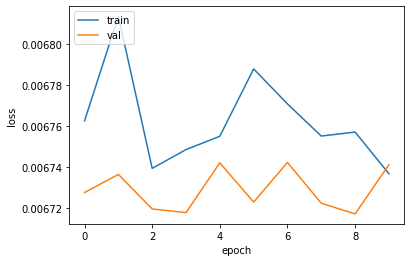

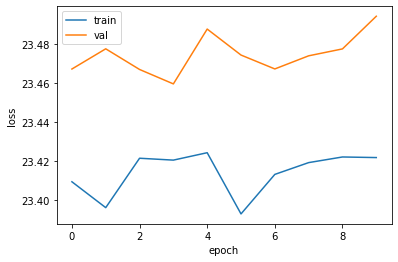

In [108]:
print(history.history.keys())
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['PSNR'], label='train')
plt.plot(history.history['val_PSNR'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

In [61]:
!zip -r experiments.zip *.h5 *.pkl

updating: model_isp_final.h5 (deflated 62%)
updating: model_isp_final_233.h5 (deflated 62%)
updating: model_isp_final_233_last.h5 (deflated 64%)
updating: model_isp_final_last.h5 (deflated 64%)
updating: history_model_isp_final.pkl (deflated 49%)
updating: history_model_isp_final_233.pkl (deflated 51%)
  adding: model_isp_final_234.h5 (deflated 62%)
  adding: model_isp_final_234_last.h5 (deflated 64%)
  adding: history_model_isp_final_234.pkl (deflated 50%)


# Submission

In [109]:
!rm -r submission test
!rm -r *.zip
!rm *.tflite
!mkdir submission

rm: cannot remove 'test': No such file or directory
rm: cannot remove '*.zip': No such file or directory


In [110]:
def keras2tflite (model, name):
    '''
    Reference: https://github.com/aiff22/MAI-2021-Workshop/blob/main/keras_to_tflite.py
    '''
    print ('converting...')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Be very careful here:
    # "experimental_new_converter" is enabled by default in TensorFlow 2.2+. However, using the new MLIR TFLite
    # converter might result in corrupted / incorrect TFLite models for some particular architectures. Therefore, the
    # best option is to perform the conversion using both the new and old converter and check the results in each case:
    converter.experimental_new_converter = False
    tflite_model = converter.convert()
    open(f"{name}", "wb").write(tflite_model)
    print ('saved!')

In [111]:
'''
Reference: 
https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp/blob/master/test_model.py#L66-#L70
'''

def extract_bayer_channels(raw):
    '''BGRG RAW Unnormalized'''
    # Reshape the input bayer image
    ch_B  = raw[1::2, 1::2]
    ch_Gb = raw[0::2, 1::2]
    ch_R  = raw[0::2, 0::2]
    ch_Gr = raw[1::2, 0::2]
    RAW_combined = np.dstack((ch_B, ch_Gb, ch_R, ch_Gr)) #ch_R, ch_Gr, ch_B, ch_Gb
    #RAW_norm = RAW_combined.astype(np.float32) / (4 * 255)
    return RAW_combined

def preprocess_func(image_path):
    I = np.asarray(imageio.imread(image_path))
    I = extract_bayer_channels(I)
    I = I[0:256//2, 0:256//2, :]
    I = np.reshape(I, [1, I.shape[0], I.shape[1], 4])
    print ('raw shape', I.shape, I.min(), I.max())
    return I

def my_preprocess_func(image_path):
    raw = tf.io.read_file(image_path)
    raw = tf.io.decode_png(raw,channels=1,dtype=tf.uint16)
    raw = tf.reshape(raw, [256, 256, 1])
    raw = tf.expand_dims(raw, 0)
    raw = tf.nn.space_to_depth (raw, 2)
    #raw = tf.squeeze(raw).numpy()
    raw = tf.cast(raw, tf.float32) 
    raw = raw / 2**12

def GRBGtoRGGB (raw):
    raw = np.squeeze(raw)
    b =raw[:,:,0]
    gb=raw[:,:,1]
    r =raw[:,:,2]
    gr=raw[:,:,3]
    raw_rggb = np.dstack((r,gr,gb,b))
    raw_rggb = np.expand_dims(raw_rggb, 0)
    return raw_rggb

def run_tflite_model(image, model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    enhanced_image = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
    enhanced_image = np.clip(enhanced_image, 0., 1.)
    enhanced_image = np.reshape(enhanced_image, 
               [int(image.shape[1] * 2.0), int(image.shape[2] * 2.0), 3])
    
    return enhanced_image

## TFLite conversion

Following the tutorial: https://github.com/aiff22/MAI-2021-Workshop/blob/main/keras_to_tflite.py

In [112]:
tf.keras.backend.clear_session()

@tf.function
def tf_normalize_raw(x):
    x = x / 4096
    return tf.cast(x, tf.float32)

@tf.function
def tf_GRBGtoRGGB (raw):
    b =raw[:,:,:,0]
    gb=raw[:,:,:,1]
    r =raw[:,:,:,2]
    gr=raw[:,:,:,3]
    raw_rggb = tf.stack((r,gr,gb,b), axis=-1)
    return raw_rggb

In [113]:
!rm model.tflite
!rm model_none.tflite

MODEL_NAME = 'model_test.tflite'
INPUT_SHAPE = (128,128,4)

model = build_model(input_shape=INPUT_SHAPE)
model.load_weights('./model_isp_final_23_46.h5')
print ('model weights loaded')

model_deploy = tf.keras.Sequential()
model_deploy.add(tf.keras.layers.Input(INPUT_SHAPE))
model_deploy.add(Lambda(tf_normalize_raw))
model_deploy.add(Lambda(tf_GRBGtoRGGB))
model_deploy.add(model)

keras2tflite(model_deploy, name=MODEL_NAME)

rm: cannot remove 'model.tflite': No such file or directory
rm: cannot remove 'model_none.tflite': No such file or directory
model weights loaded
converting...
saved!


In [114]:
MODEL_NAME = 'model.tflite'
INPUT_SHAPE = (544,960,4)

model = build_model(input_shape=INPUT_SHAPE)
model.load_weights('./model_isp_final_23_46.h5')
print ('model weights loaded')

model_deploy = tf.keras.Sequential()
model_deploy.add(tf.keras.layers.Input(INPUT_SHAPE))
model_deploy.add(Lambda(tf_normalize_raw))
model_deploy.add(Lambda(tf_GRBGtoRGGB))
model_deploy.add(model)

keras2tflite(model_deploy, name=MODEL_NAME)

model weights loaded
converting...
saved!


## Inference

Our model contains all the necessary steps to perform the inference:

```
model_deploy = tf.keras.Sequential()
model_deploy.add(tf.keras.layers.Input(INPUT_SHAPE))
model_deploy.add(Lambda(tf_normalize_raw))
model_deploy.add(Lambda(tf_GRBGtoRGGB))
model_deploy.add(model)
```

where `model` is our keras model. The `normalize_raw` is important, since the input in this challenge is not normalized, here we use the 12bit normalization. Also, the conversion from the GRBG pattern to the RGGB pattern used for training.


We can produce the resultant RGBs from the RAW sensor data using our `model.tflite` directly, as it will run in the smartphone.

As we can see, qualitative results are positive :)

**Problems?** generating the `.tflite` model using a `(None, None, 4)` input crashes.

In [115]:
challenge_ts = glob('../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/*.png')
len(challenge_ts)

2258

raw shape (1, 128, 128, 4) 324 4092
unnomalized RAW input BGRG (1, 128, 128, 4) 324 4092 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1231.png (128, 128, 4) (256, 256, 3)


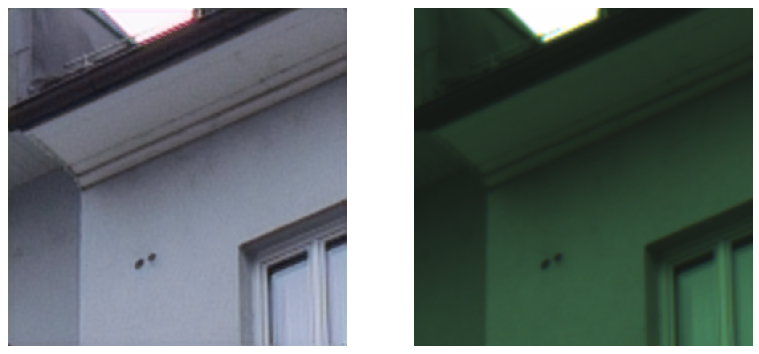

raw shape (1, 128, 128, 4) 256 968
unnomalized RAW input BGRG (1, 128, 128, 4) 256 968 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1017.png (128, 128, 4) (256, 256, 3)


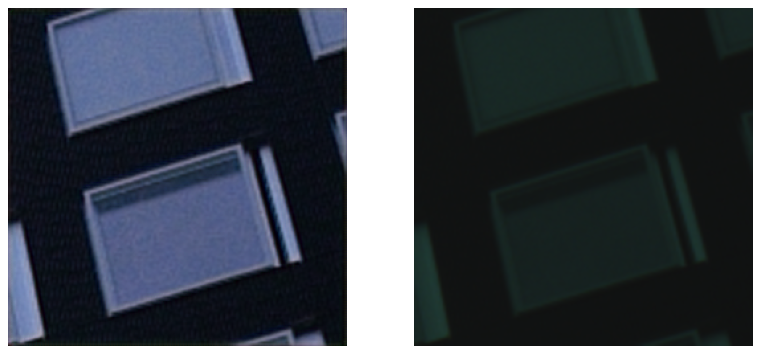

raw shape (1, 128, 128, 4) 344 1932
unnomalized RAW input BGRG (1, 128, 128, 4) 344 1932 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/2015.png (128, 128, 4) (256, 256, 3)


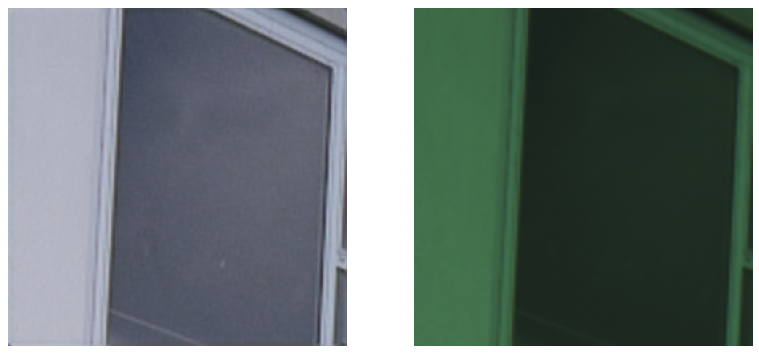

raw shape (1, 128, 128, 4) 340 4092
unnomalized RAW input BGRG (1, 128, 128, 4) 340 4092 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1522.png (128, 128, 4) (256, 256, 3)


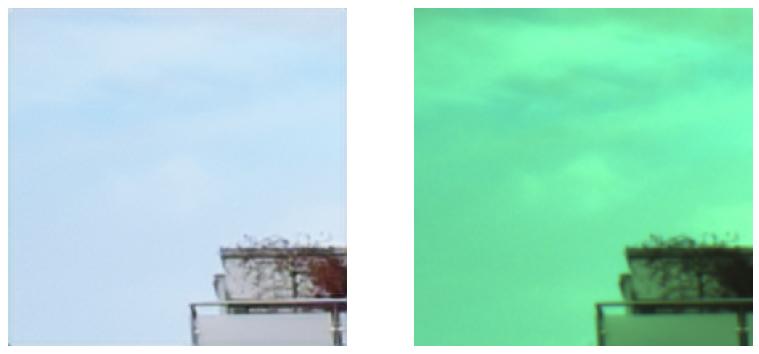

raw shape (1, 128, 128, 4) 308 2064
unnomalized RAW input BGRG (1, 128, 128, 4) 308 2064 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/2064.png (128, 128, 4) (256, 256, 3)


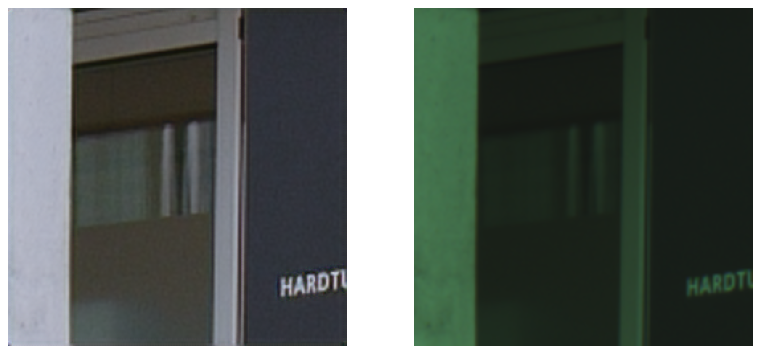

raw shape (1, 128, 128, 4) 252 4092
unnomalized RAW input BGRG (1, 128, 128, 4) 252 4092 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/641.png (128, 128, 4) (256, 256, 3)


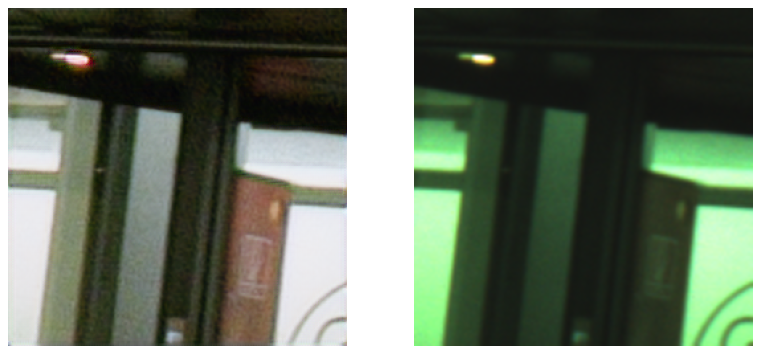

raw shape (1, 128, 128, 4) 296 2008
unnomalized RAW input BGRG (1, 128, 128, 4) 296 2008 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1088.png (128, 128, 4) (256, 256, 3)


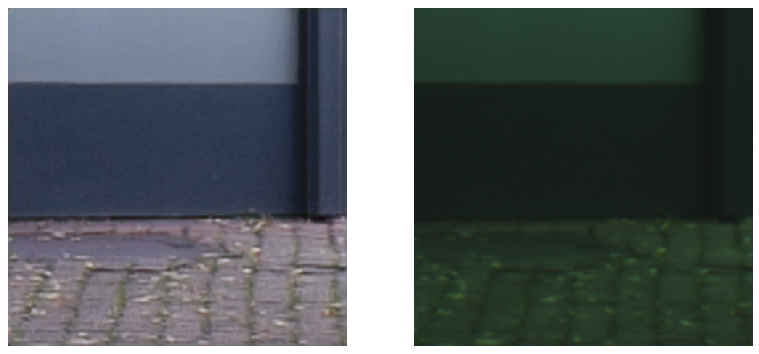

raw shape (1, 128, 128, 4) 260 1920
unnomalized RAW input BGRG (1, 128, 128, 4) 260 1920 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/173.png (128, 128, 4) (256, 256, 3)


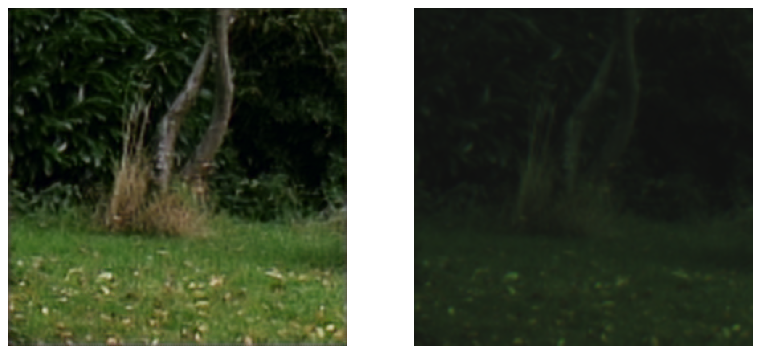

raw shape (1, 128, 128, 4) 252 992
unnomalized RAW input BGRG (1, 128, 128, 4) 252 992 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1746.png (128, 128, 4) (256, 256, 3)


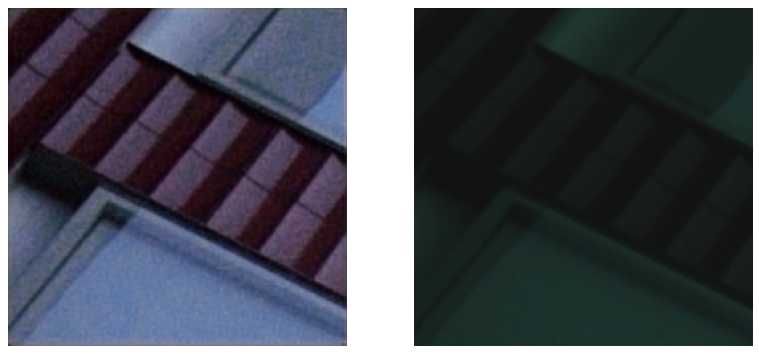

raw shape (1, 128, 128, 4) 260 3968
unnomalized RAW input BGRG (1, 128, 128, 4) 260 3968 uint16
../input/mai-aim-learned-isp-data/MAI2021_LearnedISP_valid_raw/1958.png (128, 128, 4) (256, 256, 3)


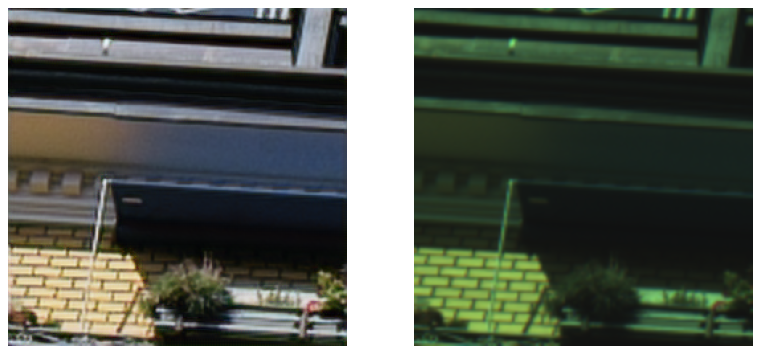

In [116]:
for test_image in challenge_ts[:10]:
   
    raw = preprocess_func(test_image)
    print ('unnomalized RAW input BGRG', raw.shape, raw.min(), raw.max(), raw.dtype)
    raw = raw.astype(np.float32)
    rgb = run_tflite_model(raw, model_path='model_test.tflite')
    rgb = np.squeeze(rgb)
    
    ## these steps are for visualization purposes!!
    raw = (raw / 2**12).astype(np.float32)
    raw = GRBGtoRGGB(raw)
    raw = np.squeeze(raw)
    
    print (test_image, raw.shape, rgb.shape)
    plot_all([rgb, demosaic(raw)])
    del raw, rgb

# End

You can save the resultant `RGBs` and `tflite` model in a zip file and submit yourself!

Do not forget to leave a star at https://github.com/mv-lab/AISP and check the other baselines for different benchmarks.


<a href="https://github.com/mv-lab/AISP"><img src="https://i.ibb.co/725jJsB/Screenshot-from-2022-08-01-23-55-44.png" alt="AISP" border="0"></a>